# Getting started with Sentinel 2 data

**Background** As of mid-February 2018, Sentinel 2 data is available to access within the a development environment on AWS. There are a number of things that need to be done prior to gaining access to the Sentinel 2 archive. For the purpose of this notebook, we will assume you have successfully gained access to the AWS environment where Sentinel 2 data is currently housed. 

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `clear` pixels. 

**Date**: February 2018.

**Author**: Claire Krause

**Tags**
`Sentinel2`, `products`, `threeBandImage`, `threeBandImage_subplots`, `dc.list_products`, `dc.load`, `query`, `beginner`, `plot`, `image`, `pixelquality`

In [1]:
% pylab notebook
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


## Define some plotting functions for later on

In [2]:
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

def threeBandImage_subplots(ds, bands, num_cols, figsize = [10,10], projection = 'projected', left  = 0.125, 
                            right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, and plots them 
    on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    left  = 0.125  # the space on the left side of the subplots of the figure
    right = 0.9    # the space on the right side of the subplots of the figure
    bottom = 0.1   # the space on the bottom of the subplots of the figure
    top = 0.9      # the space on the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    timesteps = ds.time.size
    num_rows = int(ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, wspace = wspace, hspace = hspace)
    numbers = 0
    try:
        for ax in axes.flat:
            t, y, x = ds[bands[0]].shape
            rawimg = np.zeros((y,x,3), dtype = np.float32)
            for i, colour in enumerate(bands):
                rawimg[:,:,i] = ds[colour][numbers].values
            rawimg[rawimg == -999] = np.nan
            img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
            ax.imshow(img_toshow)
            ax.set_title(str(ds.time[numbers].values), fontweight = 'bold', fontsize = 12)
            ax.set_xticklabels(ds.x.values, fontsize = 8, rotation = 20)
            ax.set_yticklabels(ds.y.values, fontsize = 8)
            if projection == 'geographic':
                ax.set_xlabel('Longitude', fontweight = 'bold', fontsize = 10)
                ax.set_ylabel('Latitude', fontweight = 'bold', fontsize = 10)
            else:
                ax.set_xlabel('Eastings', fontweight = 'bold', fontsize = 10)
                ax.set_ylabel('Northings', fontweight = 'bold', fontsize = 10)
            numbers = numbers + 1
    except IndexError:
        # This error will pop up if there are not enough scenes to fill the number of rows x columns, so we can 
        # safely ignore it
        pass    

# See what Sentinel 2 products are currently available

In [3]:
products = s2aws.list_products()
display_columns = ['name', 'description', 'instrument', 'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
44,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,Sentinel-2A,S2MSIARD,NaN,NaN
41,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
43,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,MSI,SENTINEL_2A,S2MSI2Ap,NaN,NaN
45,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,Sentinel-2B,S2MSIARD,NaN,NaN
42,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

# Now we want to actually load and look at some data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [4]:

query = {
        'lat': (-30.655, -30.700),
        'lon': (144.802, 144.900),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2017-02-10')
        }
# use s2b_ard_granule 	 for S2B
data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

## See what came back from the extraction

In [5]:
data

<xarray.Dataset>
Dimensions:        (time: 3, x: 976, y: 596)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-04T00:27:02.026000 ...
  * y              (y) float64 -3.398e+06 -3.398e+06 -3.398e+06 -3.398e+06 ...
  * x              (x) float64 1.212e+06 1.212e+06 1.212e+06 1.212e+06 ...
Data variables:
    pixel_quality  (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    contiguity     (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    aerosol        (time, y, x) int16 970 970 962 962 965 965 965 965 971 ...
    blue           (time, y, x) int16 1070 1071 1108 1091 1051 1076 1050 ...
    green          (time, y, x) int16 1361 1378 1386 1367 1366 1355 1360 ...
    red            (time, y, x) int16 1729 1766 1760 1741 1719 1754 1714 ...
    rededge1       (time, y, x) int16 1983 1983 1969 1969 1989 1989 1972 ...
    rededge2       (time, y, x) int16 2173 2173 2149 2149 2147 2147 2214 ...
    rededge3       (time, y, x) int16 2304 2304 2307 2307 23

In [6]:
#make a mask for full timeseries 
clear_pixels = data.pixel_quality == 1
clear_data = data.where(clear_pixels)
clear_data

<xarray.Dataset>
Dimensions:        (time: 3, x: 976, y: 596)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-04T00:27:02.026000 ...
  * y              (y) float64 -3.398e+06 -3.398e+06 -3.398e+06 -3.398e+06 ...
  * x              (x) float64 1.212e+06 1.212e+06 1.212e+06 1.212e+06 ...
Data variables:
    pixel_quality  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    contiguity     (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    aerosol        (time, y, x) float64 970.0 970.0 962.0 962.0 965.0 965.0 ...
    blue           (time, y, x) float64 1.07e+03 1.071e+03 1.108e+03 ...
    green          (time, y, x) float64 1.361e+03 1.378e+03 1.386e+03 ...
    red            (time, y, x) float64 1.729e+03 1.766e+03 1.76e+03 ...
    rededge1       (time, y, x) float64 1.983e+03 1.983e+03 1.969e+03 ...
    rededge2       (time, y, x) float64 2.173e+03 2.173e+03 2.149e+03 ...
    rededge3       (time, y, x) float64 2.304e+03 2.304e+03 2.307e+03 ...
 

# About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `aerosol` | 1 | 443 | 60 | 20 |
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `rededge1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `rededge2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `rededge3` | 7 | 783 | 20 | 20 |
| NIR | `nir` | 8 | 842 | 10 | 115 |
| Narrow NIR | `rededge4` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `swir1` | 11 | 1610 | 20 | 90 |
| SWIR | `swir2` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

## Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `t_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

Note that the `t_nbar` data insert a missing value (`-9999`) into the dataset to denote a terrain shadow. This should be converted to a `NaN` value before using this data to avoid treating it as a valid value.


For more information on these corrections, see the explanation of the [Landsat archive data](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

# Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

In [7]:
threeBandImage(clear_data, bands = ['red', 'green', 'blue'], time = 1)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/skimage/exposure/exposure.py:129: RuntimeWarning: invalid value encountered in true_divide
  img_cdf = img_cdf / float(img_cdf[-1])


<IPython.core.display.Javascript object>

clear_pixels = np.where(data.pixel_quality == 2 or data.pixel_quality == 3)

#plotting NDVI:

cbr_NDVI = (data.nir1 - data.red)/(data.nir1 + data.red)


cbr_NDVI

clean_ndvi = cbr_NDVI.where(clear_pixels)

cbr_NDVI_once = clean_ndvi.isel(time=6)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('NDVI')
ax.imshow(cbr_NDVI_once, cmap='RdYlGn', interpolation='nearest')

# Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

# Compare some scenes side-by-side

# Filter scenes using pixel quality

A pixel quality dataset is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows. 

The pixel quality field contains values from 0 to 5. 

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

In the Sentinel data, `clear` pixels are denoted as `1` in the pixel quality mask. We can use this to filter a cloudy image. 

## Here is the cloudy image we would like to mask

## Plot up the pixel quality information for the same scene

## Now use the pixel quality information to create a mask, and apply it to the spectral data

In [17]:
clear_pixels1 = data.pixel_quality != 2
clear_pixels2 = data.pixel_quality != 3


In [18]:
clear_master = clear_pixels1 * clear_pixels2


In [19]:
Clear_Canberra1 = data.where(clear_pixels1)


<IPython.core.display.Javascript object>


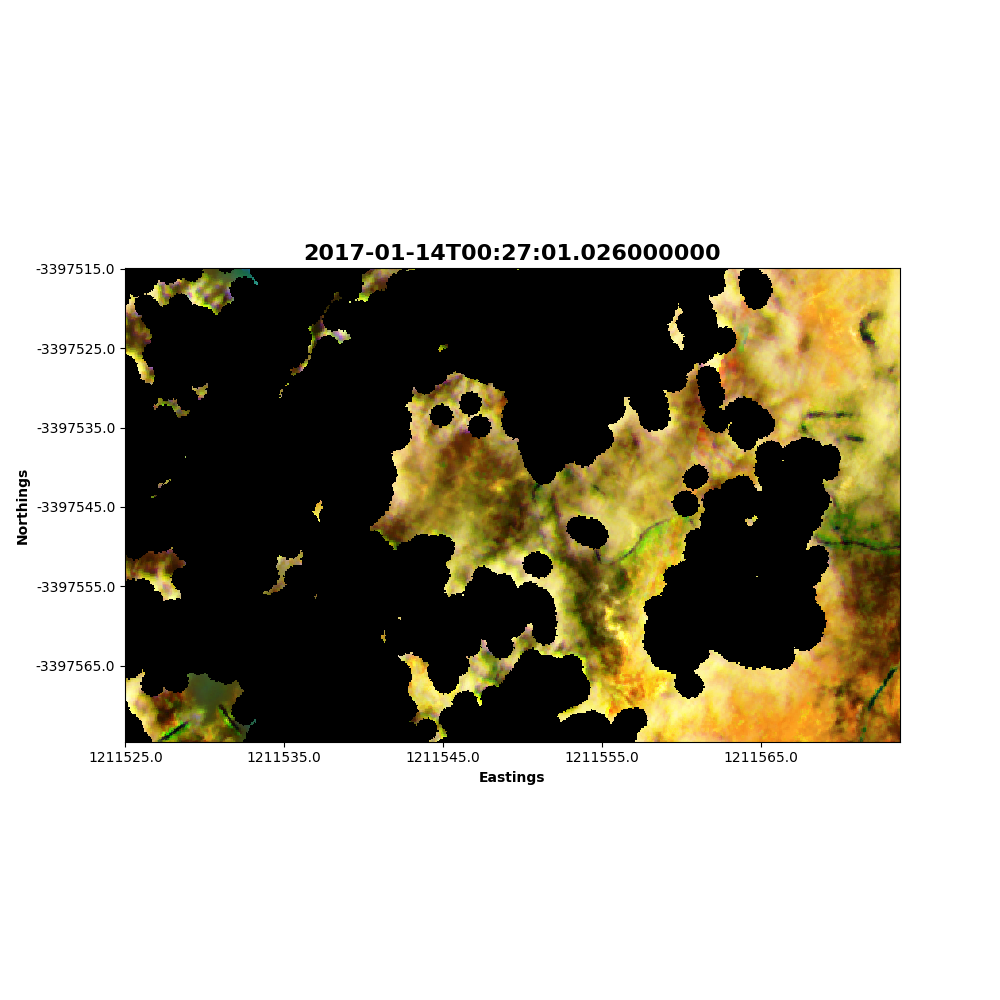

In [22]:
threeBandImage(Clear_Canberra1, bands = ['swir1','nir2','green'], time = 2)

In [23]:
Clear_Canberra2 = data.where(clear_pixels2)


<IPython.core.display.Javascript object>


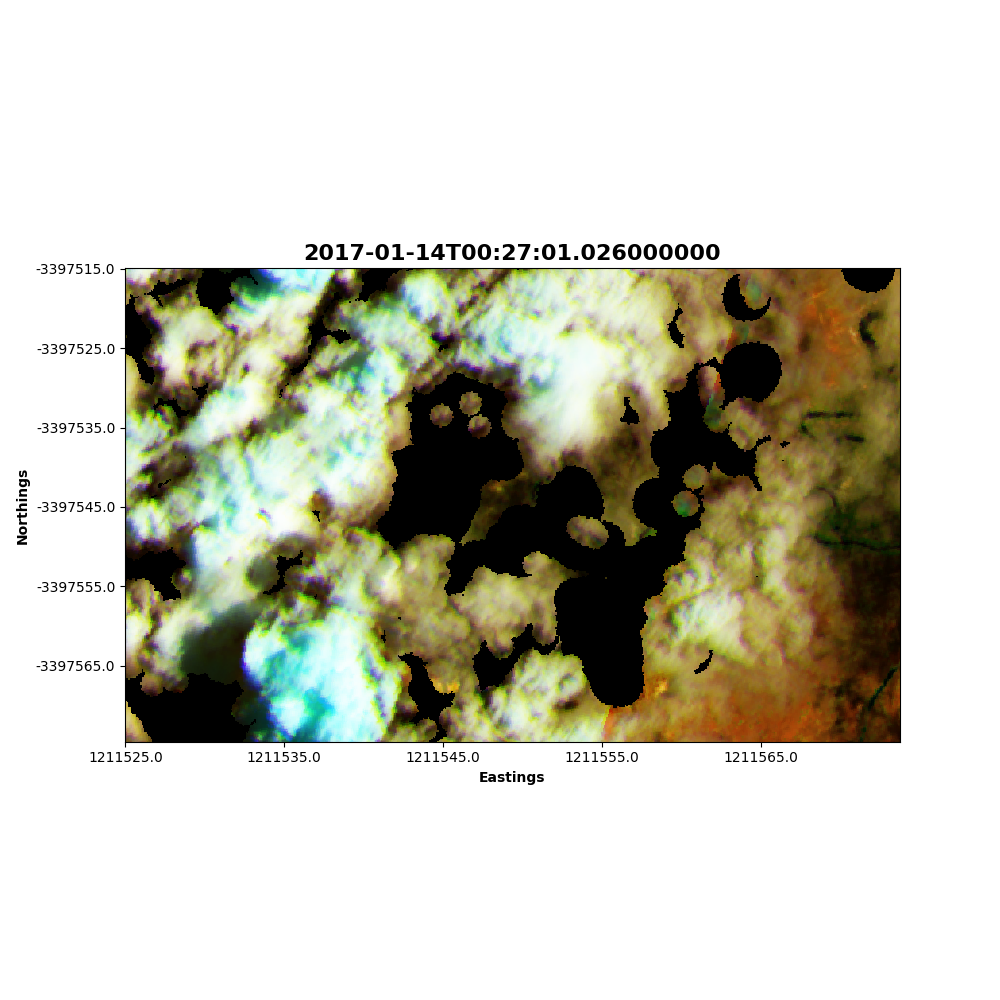

In [24]:
threeBandImage(Clear_Canberra2, bands = ['swir1','nir2','green'], time = 2)

In [25]:
Clear_Canberra3 = data.where(clear_master)

<IPython.core.display.Javascript object>


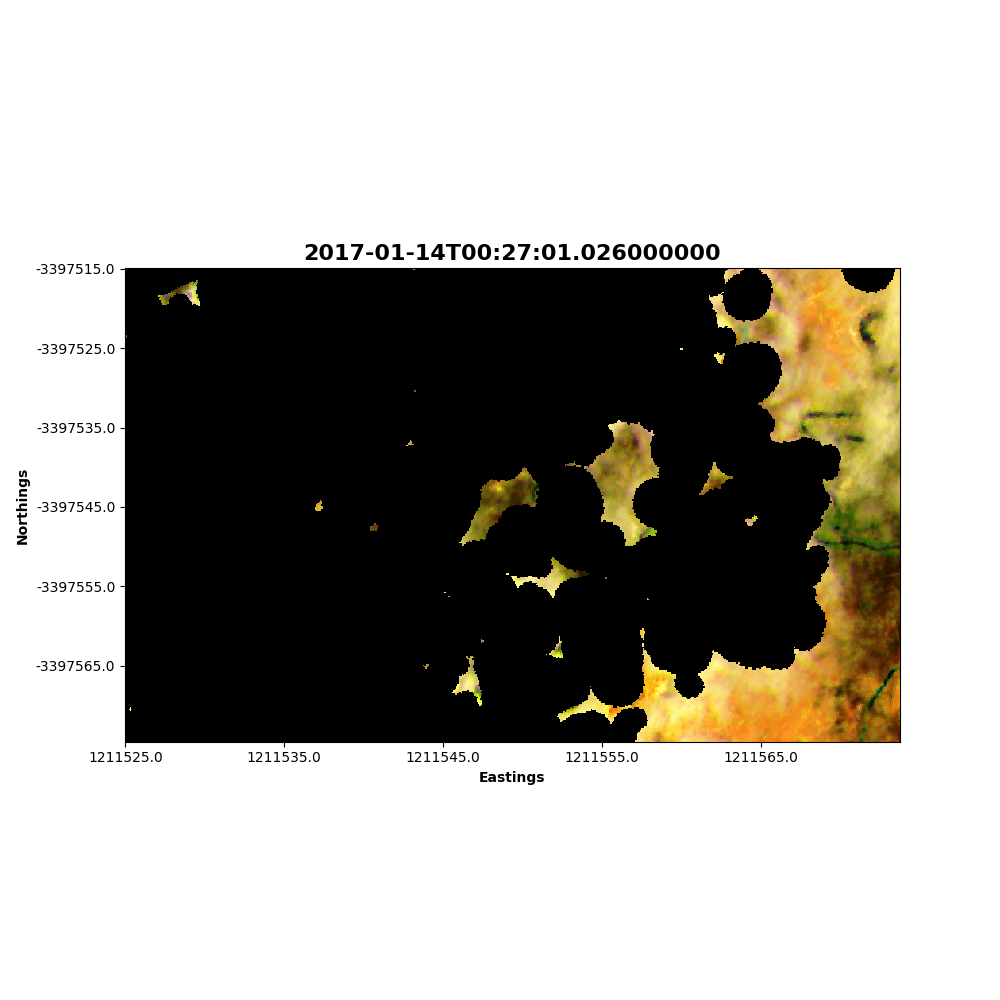

In [26]:
threeBandImage(Clear_Canberra3, bands = ['swir1','nir2','green'], time = 2)

In [16]:
threeBandImage(Clear_Canberra, bands = ['swir1','nir2','green'], time = 2)


NameError: name 'Clear_Canberra' is not defined